# Clustering for Spray Chart
__Problem:__ Given a batter/pitcher matchup, generate an expected spracy chart for this matchup. We want to be able to use this spray chart to have better judgement when positioning our infielders.

__Motivation:__ The idea behind this project is to smooth out the expected spray charts for a batter/pitcher match up.

__Hypothesis:__ That we can cluster pitchers and batter so we can get a smoother spray chart, which will lead to better shifts. For batters we will cluster with respect to average horizontal hit angle. For pitchers we will cluster with respect to average pitch characteristics and cluster again with respect to pitch usage distribution. The idea behind that is that if a pitcher throws 97mph but relies on his fastball a lot, then it is easier for the batter to cheat to. We will first get the two clusters for the pitchers

__Data:__ The data I will be using will be pitch level data that was scraped from pybaseball. I scraped this data in a seperate notebook and wrote them out to csv files so I would not have to rescrape the data everytime I restart the notebook. I will look at the 2015 through 2022 seasons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
def pitcher_data():
    """
    This function will read in the csv files and clean them and will return a single dataframe.
    """
    data = pd.DataFrame()
    for year in range(2015, 2023):
        year_df = pd.read_csv(f'data/season_{year}.csv')
        
        # get the columns that are important to the pitchers
        pitcher_columns = ['pitch_type', 'pitch_name', 'game_year', 'release_speed', 'pfx_x', 'pfx_z',
                           'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 
                           'stand', 'p_throws', 'plate_x', 'plate_z']

        pitch_df = year_df[pitcher_columns].copy()
        pitch_df = pitch_df.dropna()

        # get only the pitches in the main 8 pitch types. I explored this in a seperate notebook and these were the 8 mostly used
        # other pitches were usually outliers
        pitch_df = pitch_df[pitch_df.pitch_type.isin(['FF', 'SI', 'SL', 'CH', 
                                                  'CU', 'FC', 'KC', 'FS',])]
        # rename horizontal and vertical break
        pitch_df = pitch_df.rename(columns={"pfx_x": "break_x", "pfx_z": "break_z"})
        data = pd.concat([data, pitch_df])
        
    return data

In [3]:
df = pitcher_data()

In [4]:
df.head()

,pitch_type,pitch_name,game_year,release_speed,break_x,break_z,release_pos_x,release_pos_z,player_name,batter,pitcher,stand,p_throws,plate_x,plate_z
0,FF,4-Seam Fastball,2015,96.1,-0.27,1.70,-1.92,5.95,"Davis, Wade",527038,451584,R,R,-0.93,1.62
1,FC,Cutter,2015,93.1,0.24,0.72,-1.50,6.02,"Davis, Wade",527038,451584,R,R,0.78,1.55
2,FF,4-Seam Fastball,2015,97.0,-0.50,1.41,-1.37,6.08,"Davis, Wade",527038,451584,R,R,1.32,2.47
3,FC,Cutter,2015,93.6,0.32,0.80,-1.25,6.06,"Davis, Wade",527038,451584,R,R,2.92,2.23
4,FF,4-Seam Fastball,2015,97.1,-0.76,1.63,-1.49,6.08,"Davis, Wade",527038,451584,R,R,0.26,2.74


## Pitcher Clustering Approach
- __Idea:__ Given a pitcher, we want to find similar pitchers to use for this given pitchers spray chart
- __Types of Clustering:__ 
    - __Pitch Characteristic Clustering:__ This clustering technique will be a KMeans clustering algorithm used on the pitchers avergae pitch characteristics like velocity and break. The idea behind this is that if the pitcher throws 100mph then the batter will have less time to swing, causing the batter to pull the ball less.
    - __Pitch Distribution Clustering:__ This clustering technique was motivated by a former teammate of mine, who played in the American Association with me. He was an outfielder for the Souix City Explorers and I asked him what caused him to be able to pull a ball off a pitcher who threw mid to high 90's but not be able to pull a ball off of a pitcher that threw mid to high 80's. He said its is due to the pitcher's pitch usage distribution. He said he had to be timed to the pitcher's fastball and if the pitcher was a 1 and a half pitch pitcher, then it was easy to cheat to the fastball and pull it. But, if the pitcher threw multiple pitches for strikes then he had to have a better approach at the plate. He said he would have to be time to the fastball to right field and be time to the offspeed to left field, so with one swing he could potentionally cover 2 pitches. But with my pitching philosophy, that was relient on preceived velocity, then he would have a very hard time trying to cover these 2 pitches. Preceived velocity is essentially the time it take the batter to hit the pitch square. So a 90 mph fastball in the middle of the plate looks like 90, 90mph inside looks like 92, and 90 outside looks like 88. This creates a 4mph velocity spread. Now if I can change speeds with my 90mph fastball then I can make it harder on the batter. So if I step it up to 91 inside then it looks like 93mph and if I back off and throw an 87 away, then it looks like 85, creating an 8mph velocity spread with one pitch which is much harder to cover. Now when we add an offspeed pitch to this mix, then it makes it much more challenging on the batter to cover that spread which will cause the batters spray chart to be much different than if the batter was facing a fastball heavy pitcher.
- __Notes:__ I will consider the pitcher and the year for a given pitcher. This is because if a pitcher, like Justin Verlander, is a high velocity pitcher one year, low velocity pitcher another year, and then returns back to a high velocity pitcher, can cause the pitcher to be grouped with pitchers that he is not similar to at the time.

In [5]:
# verlander's average velocities from 2015 to 2022
verlander_averages = df[df.player_name == 'Verlander, Justin'].groupby(['game_year', 'pitch_type']).mean().reset_index()
verlander_averages = verlander_averages[['game_year', 'pitch_type', 'release_speed', 'break_x', 'break_z']]
verlander_averages[verlander_averages.pitch_type == 'FF']

,game_year,pitch_type,release_speed,break_x,break_z
2,2015,FF,93.396505,-1.090119,1.727824
6,2016,FF,94.079698,-1.181313,1.647720
11,2017,FF,95.378954,-1.127410,1.468865
17,2018,FF,95.114154,-0.911218,1.686633
21,2019,FF,94.596860,-0.836482,1.716668
25,2020,FF,94.925000,-1.075750,1.611500
29,2022,FF,95.021532,-0.793774,1.593452


### Pitcher Characteristic Clustering
- I will seperate right handed pitchers from left handed pitchers. 
- I will also separate fastballs from offspeed pitches to ensure that DeGrom's changeup is not clustered with a bunch of fastballs.

In [6]:
# we need to get the pitch averages per pitcher.
average_pitch = df.groupby(['player_name', 'pitcher', 'game_year', 'pitch_type', 'p_throws']).mean()[['release_speed', 'break_x', 'break_z']].reset_index()

In [7]:
average_pitch

,player_name,pitcher,game_year,pitch_type,p_throws,release_speed,break_x,break_z
0,"Aardsma, David",430911,2015,FF,R,92.055385,-0.790277,1.650338
1,"Aardsma, David",430911,2015,FS,R,84.306897,-0.936897,0.817241
2,"Aardsma, David",430911,2015,SL,R,81.638400,-0.133840,0.218000
3,"Abad, Fernando",472551,2015,CH,L,73.217117,0.791441,1.433784
4,"Abad, Fernando",472551,2015,FC,L,86.119643,-0.096429,0.740625
...,...,...,...,...,...,...,...,...
26998,"Álvarez, José",501625,2021,SL,L,81.444444,-0.412424,0.362222
26999,"Álvarez, José",501625,2022,CH,L,81.476042,1.357083,0.306875
27000,"Álvarez, José",501625,2022,FF,L,91.390909,0.823636,1.250000
27001,"Álvarez, José",501625,2022,SI,L,90.794245,1.362518,0.798129


In [8]:
# create the pitcher year column so we can have a cluster mapping
average_pitch['pitcher_year'] = average_pitch.pitcher.astype(str) + '_' + average_pitch.pitch_type.astype(str) + '_' + average_pitch.game_year.astype(str)

In [9]:
average_pitch.head(2)

,player_name,pitcher,game_year,pitch_type,p_throws,release_speed,break_x,break_z,pitcher_year
0,"Aardsma, David",430911,2015,FF,R,92.055385,-0.790277,1.650338,430911_FF_2015
1,"Aardsma, David",430911,2015,FS,R,84.306897,-0.936897,0.817241,430911_FS_2015


In [10]:
from sklearn.cluster import KMeans

def cluster_pitch_characteristics(df):
    """
    This function takes in average_df and returns the dataframe with the cluster label
    """
    fastballs = ['FF', 'SI', 'FC']
    offspeed = ['SL', 'CU', 'CH', 'FS', 'KC']

    handedness = ['R', 'L']

    # initialize a dataframe
    cluster_df = pd.DataFrame()
    for hand in handedness:
        # narrow down the dataframe to just the pitcher handedness
        hand_df = average_pitch[average_pitch.p_throws == hand].copy()
        # narrow down to fastball and offspeed pitches
        fastball_df = hand_df[hand_df.pitch_type.isin(fastballs)].copy()
        offspeed_df = hand_df[hand_df.pitch_type.isin(offspeed)].copy()

        # KMeans clustering
        features = ['release_speed', 'break_x', 'break_z']    # the features we are interested in clustering with respect to.
        kmeans_fastball = KMeans(n_clusters=40).fit(fastball_df[features])
        kmeans_offspeed = KMeans(n_clusters=40).fit(offspeed_df[features])

        # create a new column for the labels
        fastball_df['pitch_cluster'] = [hand + '_fastball_' + str(cluster) for cluster in kmeans_fastball.labels_]
        offspeed_df['pitch_cluster'] = [hand + '_offspeed_' + str(cluster) for cluster in kmeans_offspeed.labels_]

        cluster_df = pd.concat([cluster_df, fastball_df, offspeed_df])
    
    return cluster_df.sort_index()

In [11]:
pitch_characteristic_df = cluster_pitch_characteristics(average_pitch)
pitch_characteristic_df.head()

,player_name,pitcher,game_year,pitch_type,p_throws,release_speed,break_x,break_z,pitcher_year,pitch_cluster
0,"Aardsma, David",430911,2015,FF,R,92.055385,-0.790277,1.650338,430911_FF_2015,R_fastball_21
1,"Aardsma, David",430911,2015,FS,R,84.306897,-0.936897,0.817241,430911_FS_2015,R_offspeed_9
2,"Aardsma, David",430911,2015,SL,R,81.638400,-0.133840,0.218000,430911_SL_2015,R_offspeed_20
3,"Abad, Fernando",472551,2015,CH,L,73.217117,0.791441,1.433784,472551_CH_2015,L_offspeed_9
4,"Abad, Fernando",472551,2015,FC,L,86.119643,-0.096429,0.740625,472551_FC_2015,L_fastball_23


## Pitch Distribution Cluster
- Now lets get the pitch distribution cluster. We will need to get the percentage a pitcher throws a certain pitch.

In [12]:
df.head(2)

,pitch_type,pitch_name,game_year,release_speed,break_x,break_z,release_pos_x,release_pos_z,player_name,batter,pitcher,stand,p_throws,plate_x,plate_z
0,FF,4-Seam Fastball,2015,96.1,-0.27,1.70,-1.92,5.95,"Davis, Wade",527038,451584,R,R,-0.93,1.62
1,FC,Cutter,2015,93.1,0.24,0.72,-1.50,6.02,"Davis, Wade",527038,451584,R,R,0.78,1.55


In [13]:
count_df = df.groupby(['game_year', 'pitcher', 'p_throws', 'pitch_type']).count().reset_index().iloc[:, :5]
count_df.columns = ['game_year', 'pitcher', 'p_throws', 'pitch_type', 'pitch_count']
count_df.head(2)

,game_year,pitcher,p_throws,pitch_type,pitch_count
0,2015,112526,R,CH,205
1,2015,112526,R,CU,8


In [14]:
def get_pitch_distribution(df):
    """
    This function takes in the pitch count df and returns the pitch distribution df
    """
    count_dict = {}

    for year, pitcher_id, hand, pitch, count in np.array(df):
        pitcher_hand_ear = str(pitcher_id) + '_' + hand + '_'  + str(year)
        if pitcher_hand_ear not in count_dict.keys():
            # create the pitch count for that pitcher and year
            count_dict[pitcher_hand_ear] = {'FF': 0,
                                            'CH': 0,
                                            'CU': 0,
                                            'SI': 0,
                                            'SL': 0,
                                            'KC': 0,
                                            'FC': 0,
                                            'FS': 0}

        count_dict[pitcher_hand_ear][pitch] = count

    # now lets take this and create a dataframe from it
    count_data = []
    columns = ['pitcher', 'p_throw', 'year', 'FF', 'CH', 'CU', 'SI', 'SL', 'KC', 'FC', 'FS']
    for py, counts in count_dict.items():
        pitcher_id, hand, year_id = py.split('_')
        pitch_counts = list(counts.values())
        row = [pitcher_id, hand, year_id] + pitch_counts
        count_data.append(row)

    pitch_count_df = pd.DataFrame(data=count_data, columns=columns)


    # create a total column
    pitch_count_df['total'] = pitch_count_df.iloc[:, 3:].sum(axis=1)

    # divide by the total to get a prob distribution 
    pitch_count_df.iloc[:, 3:-1] = pitch_count_df.iloc[:, 3:-1].div(pitch_count_df['total'], axis='rows')

    # drop the total column
    pitch_count_df = pitch_count_df.iloc[:, :-1]
    
    return pitch_count_df

In [15]:
pitch_dist_df = get_pitch_distribution(count_df)
pitch_dist_df.head()

,pitcher,p_throw,year,FF,CH,CU,SI,SL,KC,FC,FS
0,112526,R,2015,0.290928,0.072644,0.002835,0.537562,0.096031,0.0,0.0,0.0
1,115629,R,2015,0.725753,0.076923,0.013378,0.016722,0.167224,0.0,0.0,0.0
2,136600,L,2015,0.008475,0.135593,0.093220,0.449153,0.313559,0.0,0.0,0.0
3,150116,L,2015,0.156704,0.111470,0.156704,0.329564,0.245557,0.0,0.0,0.0
4,150274,R,2015,0.000000,0.000000,0.000000,0.250000,0.750000,0.0,0.0,0.0


In [16]:
def cluster_pitch_dist(df):
    """
    This function takes in the pitch distribution df and return it with a cluster column
    """
    # now we need to cluster.
    # split up left handed pitchers and right handed pitchers
    left_pitch = df[df.p_throw == 'L'].copy()
    right_pitch = df[df.p_throw == 'R'].copy()

    # cluster
    features = ['FF', 'CH', 'CU', 'SI', 'SL', 'KC', 'FC', 'FS']
    left_kmeans = KMeans(n_clusters=40, random_state=0).fit(left_pitch[features])
    right_kmeans = KMeans(n_clusters=40, random_state=0).fit(right_pitch[features])

    left_pitch['distribution_cluster'] = ['left_' + str(cluster) for cluster in left_kmeans.labels_]
    right_pitch['distribution_cluster'] = ['right_' + str(cluster) for cluster in right_kmeans.labels_]

    cluster_df = pd.concat([left_pitch, right_pitch])
    
    return cluster_df.sort_index()

In [17]:
distribution_cluster = cluster_pitch_dist(pitch_dist_df)

### Below are the two clusters for the pitchers that we will be using to smooth out their expected spray chart.

In [18]:
# pitchers pitch distribution cluster
distribution_cluster.head()

,pitcher,p_throw,year,FF,CH,CU,SI,SL,KC,FC,FS,distribution_cluster
0,112526,R,2015,0.290928,0.072644,0.002835,0.537562,0.096031,0.0,0.0,0.0,right_18
1,115629,R,2015,0.725753,0.076923,0.013378,0.016722,0.167224,0.0,0.0,0.0,right_7
2,136600,L,2015,0.008475,0.135593,0.093220,0.449153,0.313559,0.0,0.0,0.0,left_3
3,150116,L,2015,0.156704,0.111470,0.156704,0.329564,0.245557,0.0,0.0,0.0,left_16
4,150274,R,2015,0.000000,0.000000,0.000000,0.250000,0.750000,0.0,0.0,0.0,right_13


In [19]:
# pitcher pitch characteristic cluster
pitch_characteristic_df.head()

,player_name,pitcher,game_year,pitch_type,p_throws,release_speed,break_x,break_z,pitcher_year,pitch_cluster
0,"Aardsma, David",430911,2015,FF,R,92.055385,-0.790277,1.650338,430911_FF_2015,R_fastball_21
1,"Aardsma, David",430911,2015,FS,R,84.306897,-0.936897,0.817241,430911_FS_2015,R_offspeed_9
2,"Aardsma, David",430911,2015,SL,R,81.638400,-0.133840,0.218000,430911_SL_2015,R_offspeed_20
3,"Abad, Fernando",472551,2015,CH,L,73.217117,0.791441,1.433784,472551_CH_2015,L_offspeed_9
4,"Abad, Fernando",472551,2015,FC,L,86.119643,-0.096429,0.740625,472551_FC_2015,L_fastball_23


## Next Steps:
- add these cluster mappings to the batted ball data.
- change the field x and field y to distance and horizontal angle.
- https://baseballwithr.wordpress.com/2021/04/
- Using the above link, I found an equation to change the points to make home play (0,0) and change the distance to feet

In [20]:
def get_batted_ball_data():
    """
    This function will read in all of the pybaseball data and return only the records of balls in play.
    One downside, there are a lot of missing values in the hit_distance_sc column. I can replace those missing 
    values with a calculation between the x and y coordinate. I will only use balls that have distance less
    than 120 feet because I am looking at groundballs.
    """
    data = pd.DataFrame()
    for year in range(2015, 2023):
        year_df = pd.read_csv(f'data/season_{year}.csv')
        
        # get the columns that are important to the pitchers
        batter_columns = ['pitch_type', 'pitch_name', 'game_year', 'player_name', 'batter', 'pitcher', 
                          'description', 'stand', 'p_throws', 'type', 'hit_distance_sc', 'launch_speed', 
                          'launch_angle', 'hc_x', 'hc_y', 'events']

        batter_df = year_df[batter_columns].copy()

        # get only the pitches in the main 8 pitch types. I explored this in a seperate notebook and these were the 8 mostly used
        # other pitches were usually outliers
        batter_df = batter_df[batter_df.pitch_type.isin(['FF', 'SI', 'SL', 'CH', 
                                                        'CU', 'FC', 'KC', 'FS',])]
        
        inplay_df = batter_df[batter_df.description == 'hit_into_play'].copy()
        inplay_df.loc[:, 'hc_x'] = 2.5 * (inplay_df.hc_x - 125.42)
        inplay_df.loc[:, 'hc_y'] = 2.5 * (198.27 - inplay_df.hc_y)
        
        inplay_df.loc[: , 'horizontal_angle'] = np.degrees(np.arctan(inplay_df.hc_x / inplay_df.hc_y))
        
        # drop where horizontal angle is NaN
        inplay_df = inplay_df[~inplay_df.horizontal_angle.isnull()].copy()
        
        # filter out bunts and other weird events
        excluded_events = ['sac_bunt', 'catcher_interf', 'ejection', 'sac_bunt_double_play']
        inplay_df = inplay_df[~inplay_df.events.isin(excluded_events)]
        
        # filter for missing values in distance to do the calculation for distance with the X and Y
        missing_distance = inplay_df[inplay_df.hit_distance_sc.isnull()].copy()
        not_missing_distance = inplay_df[~inplay_df.hit_distance_sc.isnull()].copy()
        
        # do the pythagorean theorem for distance
        missing_distance.loc[:, 'hit_distance_sc'] = np.sqrt(missing_distance.hc_x ** 2 + missing_distance.hc_y ** 2)
        
        season_df = pd.concat([missing_distance, not_missing_distance]).sort_index()
        data = pd.concat([data, season_df])
    
    return data

In [21]:
bip_df = get_batted_ball_data()

## Filter down the ball in play data to ground balls
- launch angle under 10 degrees.
- horizontal angle from -45 to 45
- distance under 120ft

In [22]:
# filter down the dataframe
groundball_df = bip_df[(bip_df.launch_angle <= 10) &
                       (bip_df.horizontal_angle < 45) &
                       (bip_df.horizontal_angle > -45) &
                       (bip_df.hit_distance_sc <= 120)].copy()

# grab only to columns that we need
groundball_columns = ['pitch_type', 'game_year', 'batter',
                      'pitcher', 'stand', 'p_throws', 'hit_distance_sc', 
                      'launch_speed', 'launch_angle', 'horizontal_angle']
# edit the dataframe
groundball_df = groundball_df[groundball_columns].copy()

In [23]:
groundball_df.head()

,pitch_type,game_year,batter,pitcher,stand,p_throws,hit_distance_sc,launch_speed,launch_angle,horizontal_angle
23,SI,2015,543333,112526,L,R,107.0,88.8,6.0,23.477498
34,SL,2015,444876,592665,R,R,21.0,90.0,-4.0,-44.212365
41,FF,2015,449181,592665,R,R,101.0,63.2,10.0,23.271122
49,FF,2015,460086,592665,L,R,8.0,93.3,-21.0,40.505358
78,FC,2015,543333,477003,L,L,58.0,89.1,3.0,35.189764


## Batter Cluster
- I will cluster around average pull angle
- This will be done by looking at each batter's average pull angle vs pitchers handedness
- The cluster will be 

In [24]:
def average_pull_rate(data):
    """
    This function takes in the groundball_df and
    returns a dataframe of the average pull angle
    """
    # create the key column
    key_string = data.batter.astype(str) + '_'  + data.game_year.astype(str) + '_' + data.p_throws
    data.loc[:, 'batter_year_pitcherhand'] = key_string
    data.reset_index(drop=True, inplace=True)

    # get the average horizontal angle
    pullrate_df = data.groupby(['batter_year_pitcherhand', 'stand']).mean()[['horizontal_angle']].reset_index()

    # round to the nearest 0.5
    pullrate_df.loc[:, 'rounded_pull'] = round(pullrate_df.horizontal_angle * 2) / 2 
    
    return pullrate_df

In [25]:
pullrate_df = average_pull_rate(groundball_df)
pullrate_df.head()

,batter_year_pitcherhand,stand,horizontal_angle,rounded_pull
0,112526_2015_L,R,-7.743262,-7.5
1,112526_2015_R,R,-9.809726,-10.0
2,112526_2016_L,R,-25.502597,-25.5
3,112526_2016_R,R,-20.409418,-20.5
4,112526_2017_R,R,-21.632125,-21.5


## Map the pitcher's cluster and the batter's rounded pull rate to the goundball_df

In [26]:
# pitchers pitch distribution cluster
distribution_cluster.loc[:, 'pitcher_year'] = distribution_cluster.pitcher.astype(str) + '_' + distribution_cluster.year.astype(str)
dist_cluster_df = distribution_cluster[['pitcher_year', 'distribution_cluster']]
dist_cluster_df.head()

,pitcher_year,distribution_cluster
0,112526_2015,right_18
1,115629_2015,right_7
2,136600_2015,left_3
3,150116_2015,left_16
4,150274_2015,right_13


In [27]:
# pitcher pitch characteristic cluster
characterist_columns = ['pitcher_year', 'pitch_cluster']
pitch_char_df = pitch_characteristic_df[characterist_columns].copy()

# change the column names 
pitch_char_df.columns = ['pitcher_type_year', 'pitch_cluster']
pitch_char_df.head()

,pitcher_type_year,pitch_cluster
0,430911_FF_2015,R_fastball_21
1,430911_FS_2015,R_offspeed_9
2,430911_SL_2015,R_offspeed_20
3,472551_CH_2015,L_offspeed_9
4,472551_FC_2015,L_fastball_23


In [28]:
pullrate_df = pullrate_df[['batter_year_pitcherhand', 'rounded_pull']]
pullrate_df.head()

,batter_year_pitcherhand,rounded_pull
0,112526_2015_L,-7.5
1,112526_2015_R,-10.0
2,112526_2016_L,-25.5
3,112526_2016_R,-20.5
4,112526_2017_R,-21.5


In [29]:
# map the clusters
key_string = groundball_df.pitcher.astype(str) + '_' + groundball_df.pitch_type + '_' + groundball_df.game_year.astype(str)
groundball_df.loc[:, 'pitcher_type_year'] = key_string

key_string = groundball_df.pitcher.astype(str) + '_' + groundball_df.game_year.astype(str)
groundball_df.loc[:, 'pitcher_year'] = key_string

# merge the dataframes
groundball_df = groundball_df.merge(dist_cluster_df, how='left', on='pitcher_year')
groundball_df = groundball_df.merge(pitch_char_df, how='left', on='pitcher_type_year')
groundball_df = groundball_df.merge(pullrate_df, how='left', on='batter_year_pitcherhand')

# select the columns needed now
final_columns = ['pitch_type', 'game_year', 'batter', 'pitcher', 'stand', 'p_throws',
                 'hit_distance_sc', 'launch_speed', 'launch_angle', 'horizontal_angle',
                 'distribution_cluster', 'pitch_cluster', 'rounded_pull']

df = groundball_df[final_columns]

In [30]:
df.head()

,pitch_type,game_year,batter,pitcher,stand,p_throws,hit_distance_sc,launch_speed,launch_angle,horizontal_angle,distribution_cluster,pitch_cluster,rounded_pull
0,SI,2015,543333,112526,L,R,107.0,88.8,6.0,23.477498,right_18,R_fastball_34,12.5
1,SL,2015,444876,592665,R,R,21.0,90.0,-4.0,-44.212365,right_7,R_offspeed_33,-7.0
2,FF,2015,449181,592665,R,R,101.0,63.2,10.0,23.271122,right_7,R_fastball_0,-11.0
3,FF,2015,460086,592665,L,R,8.0,93.3,-21.0,40.505358,right_7,R_fastball_0,19.0
4,FC,2015,543333,477003,L,L,58.0,89.1,3.0,35.189764,left_22,L_fastball_17,11.0


In [31]:
def get_player_names():
    """
    This function returns the names of the pitchers and batters for their player ids
    """
    pitcher_names = pd.read_csv('data/pitcher_names.csv')
    pitcher_names.loc[:, 'name'] = pitcher_names[' first_name'] + ' ' + pitcher_names.last_name
    pitcher_names = pitcher_names[['name', 'player_id']]
    pitcher_names['name'] = pitcher_names['name'].str.strip()
    
    batter_names = pd.read_csv('data/batter_names.csv')
    batter_names.loc[:, 'name'] = batter_names[' first_name'] + ' ' + batter_names.last_name
    batter_names = batter_names[['name', 'player_id']]
    batter_names['name'] = batter_names['name'].str.strip()
    
    return batter_names.drop_duplicates('player_id').reset_index(drop=True), pitcher_names.drop_duplicates('player_id').reset_index(drop=True)

In [32]:
batter_names, pitcher_names = get_player_names()

In [33]:
pitcher_names.head()

,name,player_id
0,Oliver Perez,424144
1,Adam Wainwright,425794
2,Zack Greinke,425844
3,Yadier Molina,425877
4,Justin Verlander,434378


## Lets see how the clustering changes our Expected Spray

In [34]:
def plot_infield_heatmap(dataframe, slices=17, filename=None):
    player_bip = dataframe.horizontal_angle.values
    player_spray, bins = np.histogram(player_bip, bins=slices, range=(-45, 45))
    player_spray = player_spray/np.sum(player_spray)
    
    fig, ax= plt.subplots(figsize=(15, 15))
    
    n = slices + 1
    radius = np.linspace(0, 10, n)
    radian = np.linspace(0, np.pi / 2, n)
    radian -= np.pi/4
    r, theta = np.meshgrid(radius, radian)

    ax = plt.subplot(projection="polar", facecolor='white')
    
    new_arr = []
    for i in range(n-1):
        value = [player_spray[i]] * n
        new_arr.append(value)
    new_arr = np.array(new_arr)[::-1] 
    plt.xlim(-1, 1)
    plt.ylim(0, 0.5)
    plt.axis('off')
    
    # plot spray chart
    plt.pcolor(theta, r, new_arr, cmap='Reds', alpha=0.75, label='W', shading='auto', vmax=0.17, )
    ax.spines['polar'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_theta_zero_location('N')
    ax.tick_params(labelbottom=False)
    ax.set_facecolor("None")
    
    if filename:  
        plt.savefig(filename)
        
    plt.show()

In [35]:
def pitcher_heatmap(bip_df, names_df, pitcher_name, batter_hand, year):
    """
    This function plots a pitchers heatmap vs batter handedness
    i.e. Bartolo Colon vs Right Handed Batters
    """
    # get the pitcher's id
    pitcher_id = int(names_df[names_df.name == pitcher_name].player_id.values)
    
    # filter down the bip_df
    player_df = bip_df[(bip_df.pitcher == pitcher_id) &
                       (bip_df.stand == batter_hand) &
                       (bip_df.game_year == year)].copy()
    
    plot_infield_heatmap(player_df)

In [36]:
def batter_heatmap(bip_df, names_df, batter_name, pitcher_hand, year):
    """
    This function plots a pitchers heatmap vs batter handedness
    i.e. Bartolo Colon vs Right Handed Batters
    """
    # get the pitcher's id
    batter_id = int(names_df[names_df.name == batter_name].player_id.values)
    
    # filter down the bip_df
    player_df = bip_df[(bip_df.batter == batter_id) &
                       (bip_df.p_throws == pitcher_hand) &
                       (bip_df.game_year == year)].copy()
    
    plot_infield_heatmap(player_df)

## Spray Charts for individual players

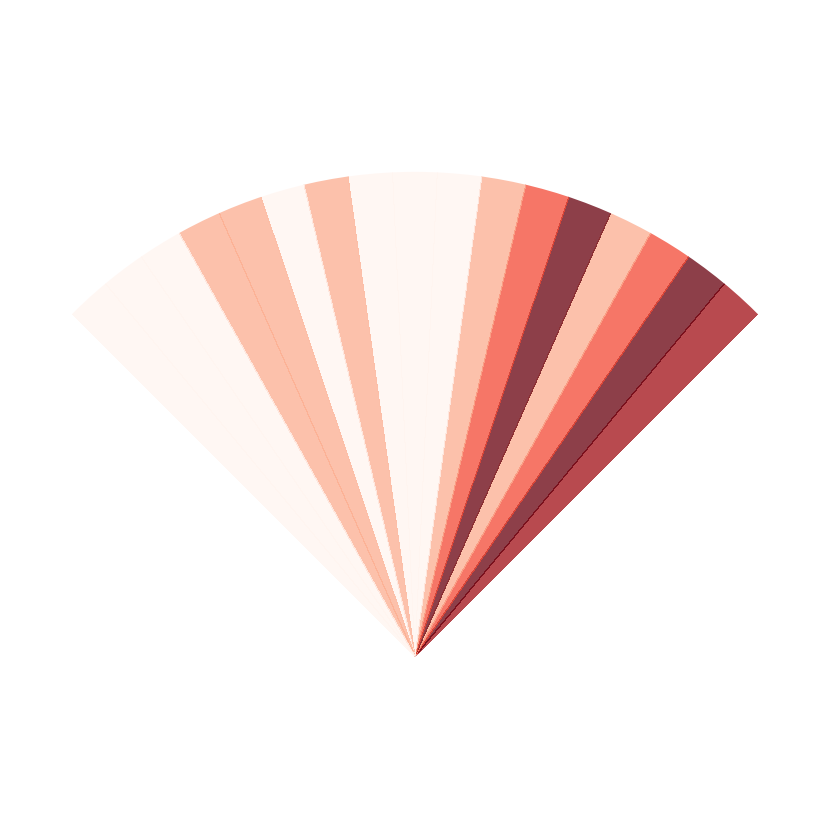

In [37]:
pitcher_heatmap(df, pitcher_names, 'Jacob deGrom', 'L', 2022)

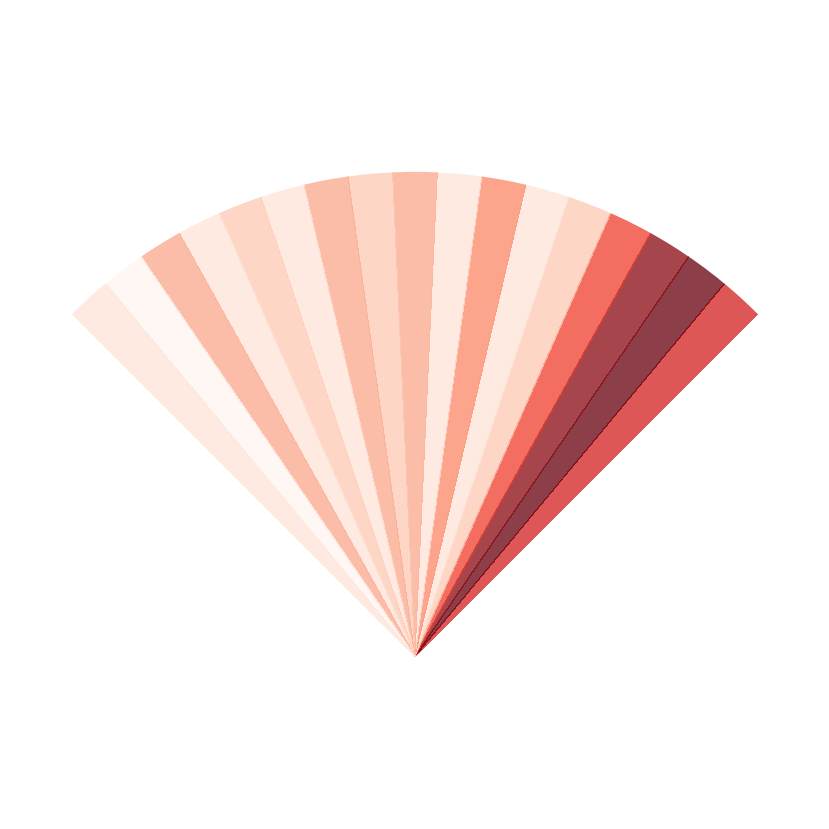

In [38]:
batter_heatmap(df, batter_names, 'Bryce Harper', 'R', 2022)

## Cluster Spray Chart

In [39]:
def pitcher_cluster_heatmap(bip_df, names_df, pitcher_name, batter_hand, year):
    """
    This function plots a pitchers heatmap and includes data from similar pitchers.
    """
    # get the pitcher's id
    pitcher_id = int(names_df[names_df.name == pitcher_name].player_id.values)
    
    # get the cluster values
    clusters = bip_df[(bip_df.pitcher == pitcher_id) &
                       (bip_df.game_year == year)][['distribution_cluster', 'pitch_cluster']]
    dist_cluster = np.array(clusters)[0][0]
    pitch_clusters = clusters.pitch_cluster.unique()
    
    # narrow down the dataframe
    cluster_df = bip_df[bip_df.stand == batter_hand].copy()
    cluster_df = cluster_df[(cluster_df.distribution_cluster == dist_cluster) |
                            (cluster_df.pitch_cluster.isin(pitch_clusters))].copy()
    plot_infield_heatmap(cluster_df)

In [40]:
def batter_cluster_heatmap(bip_df, names_df, batter_name, pitcher_hand, year):
    """
    This function will plot the heatmap for a batter and other batters with 
    similar average pull angle.
    """
    # get the batter id
    batter_id = int(names_df[names_df.name == batter_name].player_id.values)
    
    # get the batter hand
    batter_hand = bip_df[(bip_df.batter == batter_id) & (bip_df.p_throws == pitcher_hand)].stand.unique()[0]
    
    # get the batters average pull angle
    pull_angle = bip_df[(bip_df.batter == batter_id) &
                        (bip_df.game_year == year) & 
                        (bip_df.p_throws == pitcher_hand)].rounded_pull.unique()[0]
    
    # get similar batters
    batter_df = bip_df[(bip_df.p_throws == pitcher_hand) &
                       (bip_df.stand == batter_hand) &
                       (bip_df.rounded_pull <= pull_angle + 2) &
                       (bip_df.rounded_pull >= pull_angle - 2)].copy()
    plot_infield_heatmap(batter_df)

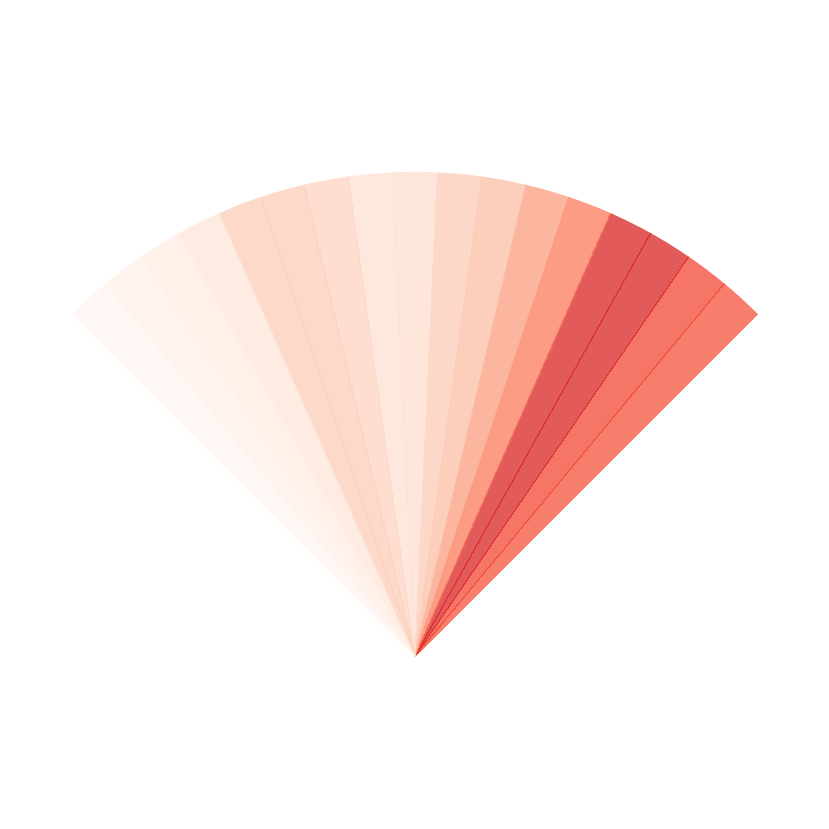

In [41]:
pitcher_cluster_heatmap(df, pitcher_names, 'Jacob deGrom', 'L', 2022)

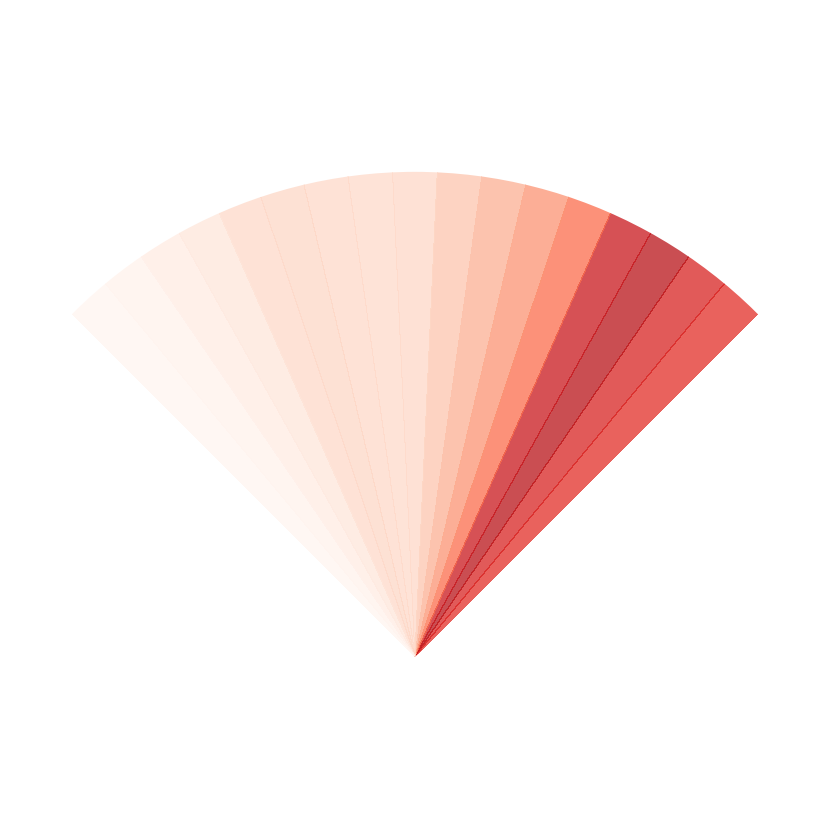

In [42]:
batter_cluster_heatmap(df, batter_names, 'Bryce Harper', 'R', 2022)

## Key Takeaways
- Notice how much deGrom's and Harpers expected spray charts smooth out when we used the information from similar players.
- Where I believe this will be most affective is for rookies because they do not have very much MLB data yet.
- Below will be the plots for a rookie batter and a rookie pitcher.

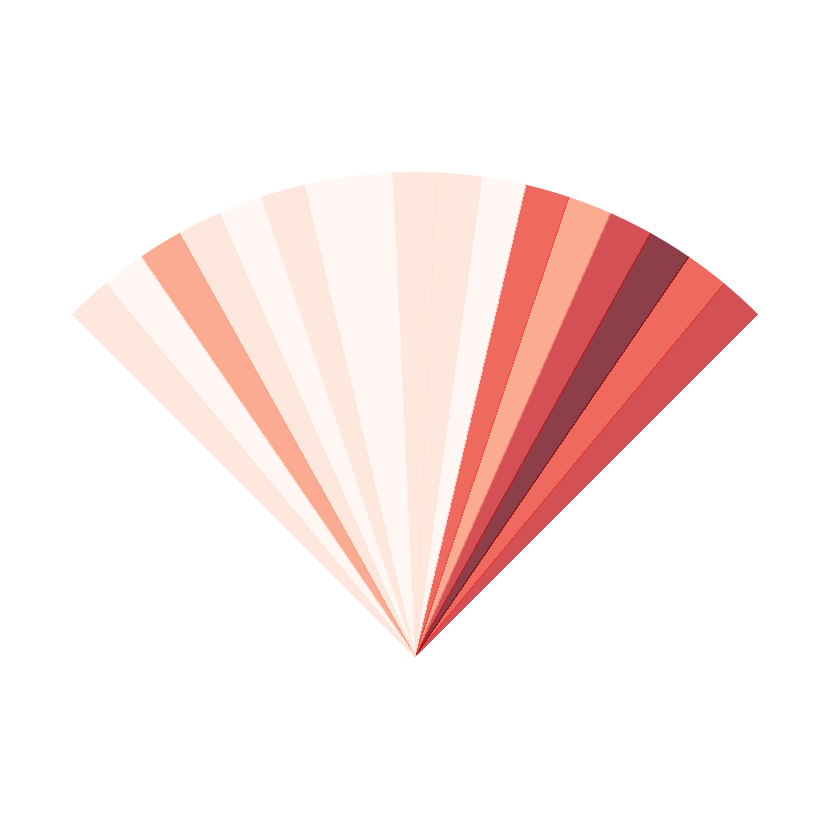

In [43]:
batter_heatmap(df, batter_names, 'TJ Friedl Jr.', 'R', 2022)

- This is a pretty choppy distribution but there is an obvious pull trend.
- Lets look at TJ's cluster

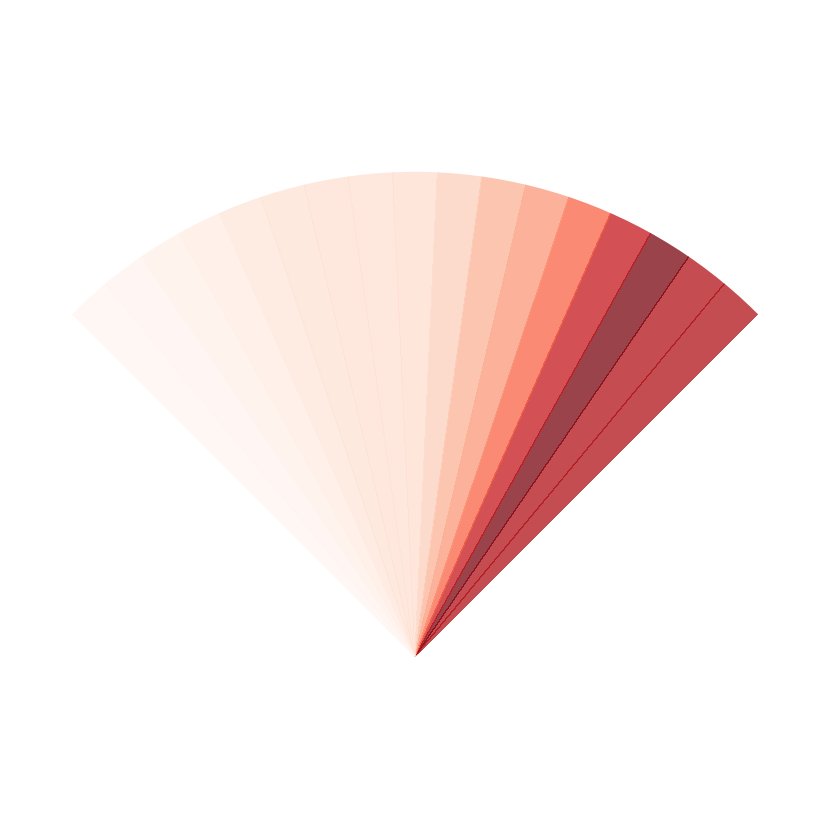

In [44]:
batter_cluster_heatmap(df, batter_names, 'TJ Friedl Jr.', 'R', 2022)

- Notice how this smooths out TJ's distribution. This cluster will act like a form of regularization if you orginization's seems to be overshifting.
- Now lets look at Spencer Strider, a rookie pitcher for the Braves.

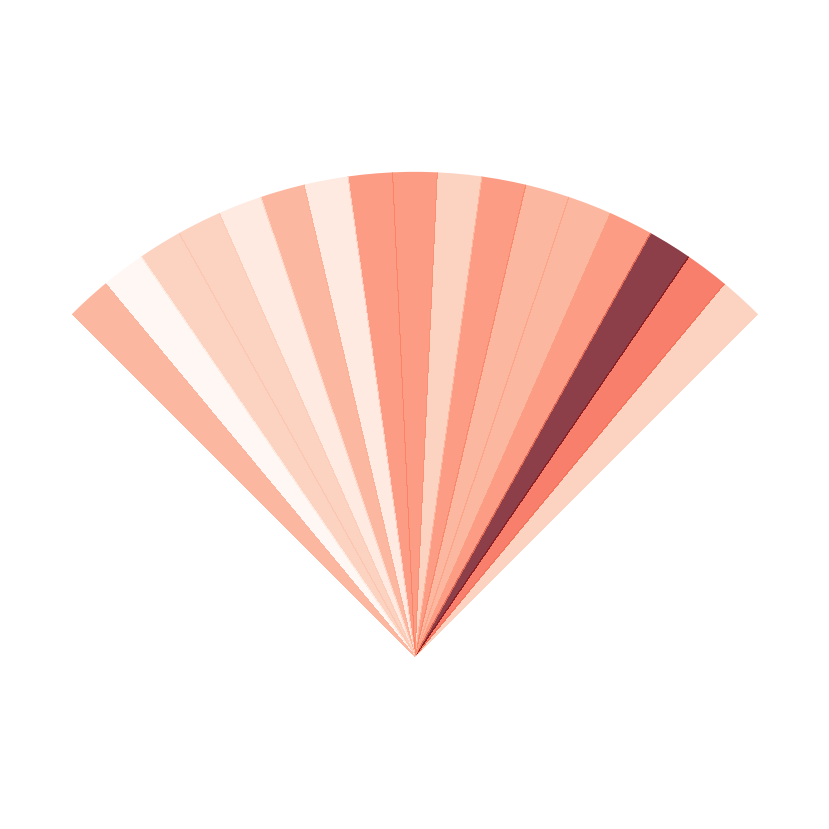

In [45]:
pitcher_heatmap(df, pitcher_names, 'Spencer Strider', 'L', 2022)

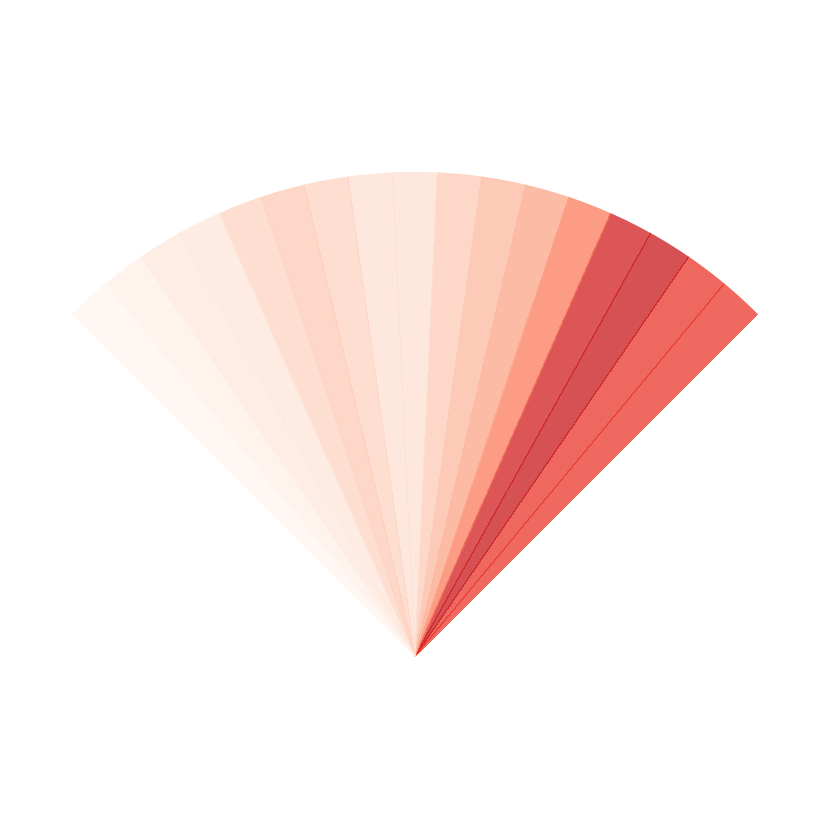

In [46]:
pitcher_cluster_heatmap(df, pitcher_names, 'Spencer Strider', 'L', 2022)

A very similar outcome occurs here as well. I hope this idea of clustering players to get a smoother expected spray chart will lead to more defensive runs saved!